<a href="https://colab.research.google.com/github/DaveStutler/G9/blob/Darian/TEAM_FRIENDSHIP_PARTICLES_WOOOOO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install uproot awkward
!pip install pandas


!pip install lumin uproot
!git clone https://github.com/SauceCat/PDPbox.git && cd PDPbox && pip install -e .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.2/334.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 697.9/697.9 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 611.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of lumin to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.3/169.3 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5

Cloning into 'PDPbox'...
remote: Enumerating objects: 2120, done.
remote: Counting objects: 100% (683/683), done.
remote: Compressing objects: 100% (334/334), done.
remote: Total 2120 (delta 383), reused 615 (delta 326), pack-reused 1437
Receiving objects: 100% (2120/2120), 301.15 MiB | 23.48 MiB/s, done.
Resolving deltas: 100% (1181/1181), done.
Updating files: 100% (76/76), done.
Obtaining file:///content/PDPbox
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uni

#Installs

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy import sparse
from scipy.sparse import csr_matrix
import uproot
import pandas as pd
import numpy
import matplotlib.pyplot as plt

## Data Exploration

#All plots from linear

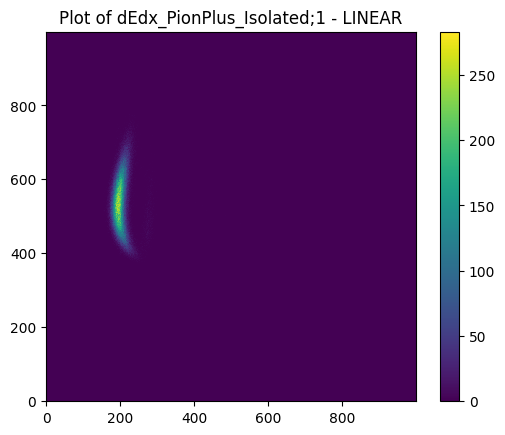

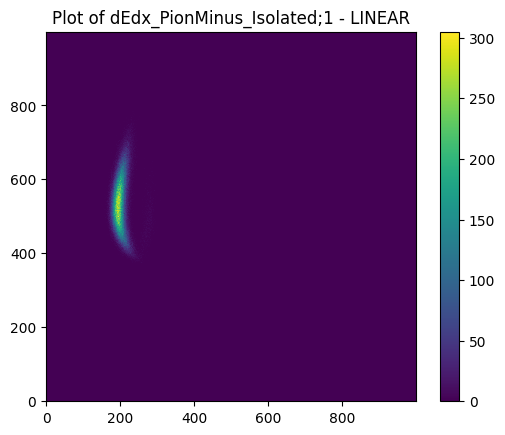

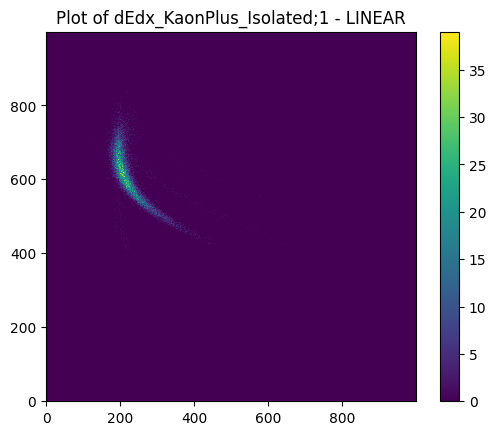

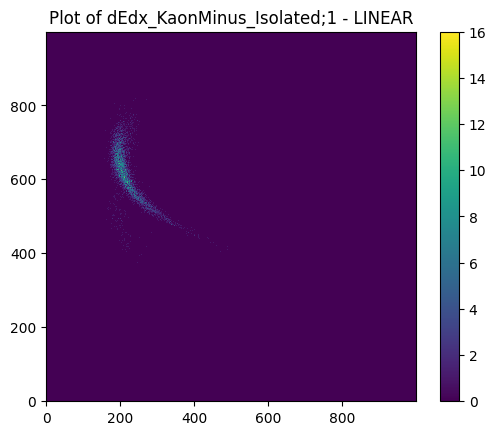

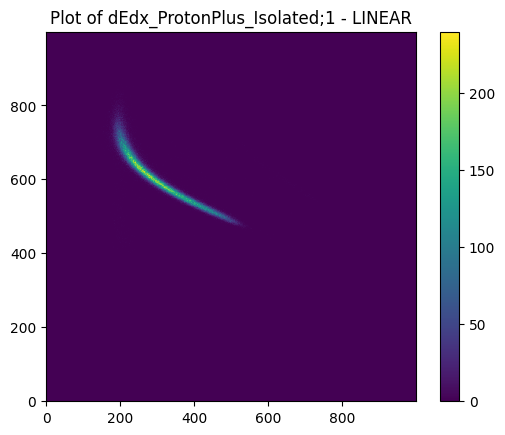

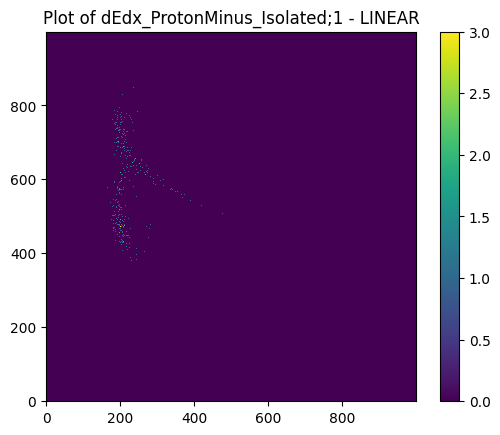

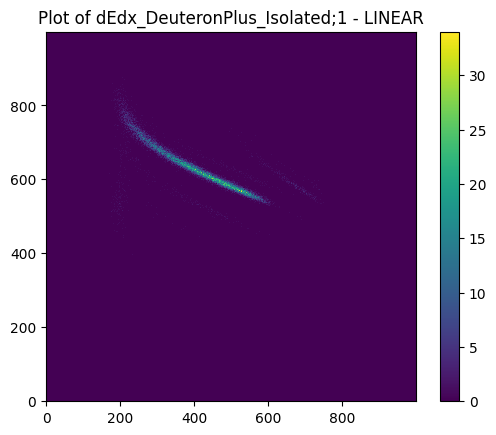

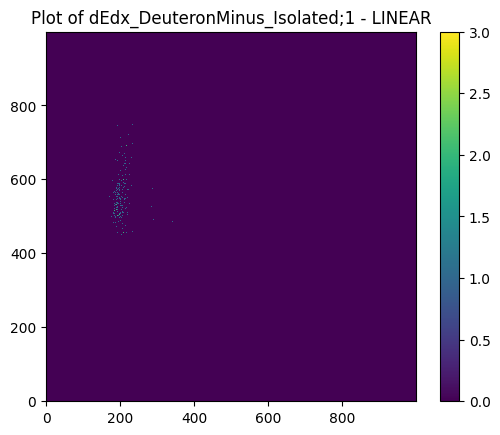

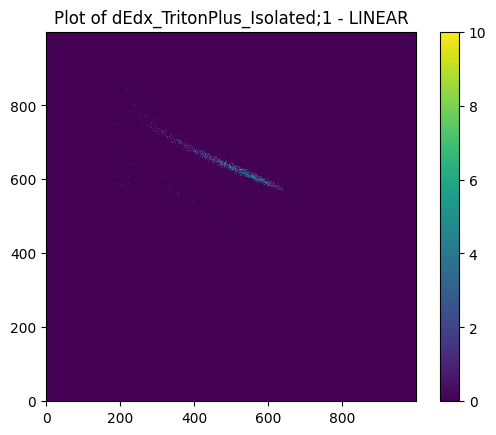

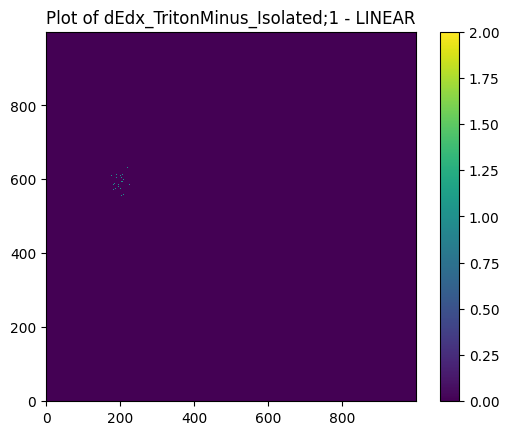

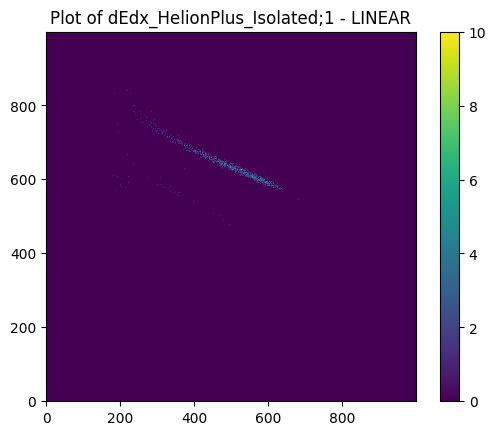

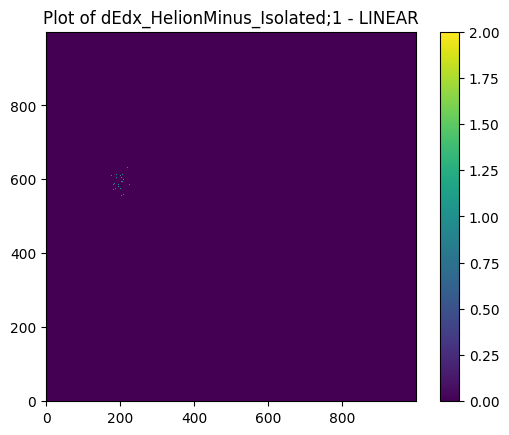

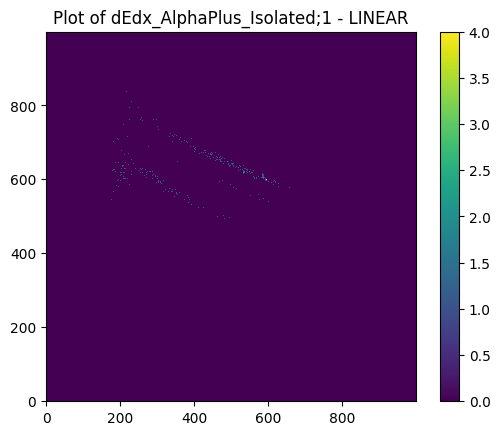

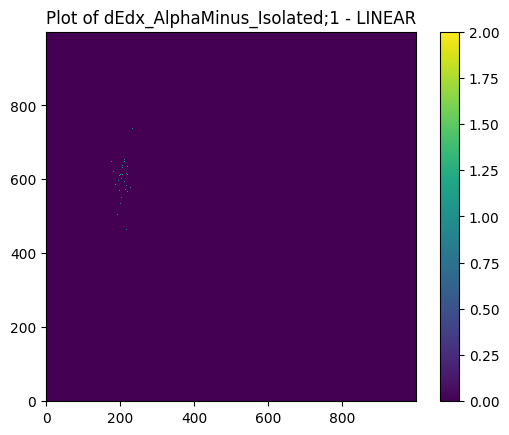

In [4]:

root_file = uproot.open("/content/Output_File_2023_02_15.root")
tree_names = ['dEdx_PionPlus_Isolated;1', 'dEdx_PionMinus_Isolated;1', 'dEdx_KaonPlus_Isolated;1',
'dEdx_KaonMinus_Isolated;1',
'dEdx_ProtonPlus_Isolated;1',
'dEdx_ProtonMinus_Isolated;1',
'dEdx_DeuteronPlus_Isolated;1',
'dEdx_DeuteronMinus_Isolated;1',
'dEdx_TritonPlus_Isolated;1',
'dEdx_TritonMinus_Isolated;1',
'dEdx_HelionPlus_Isolated;1',
'dEdx_HelionMinus_Isolated;1',
'dEdx_AlphaPlus_Isolated;1',
'dEdx_AlphaMinus_Isolated;1']


mydict = {}


for tree_name in tree_names:
    mydict[tree_name] = [root_file[tree_name].values()]
    plt.imshow(mydict[tree_name][0], cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(f"Plot of {tree_name} - LINEAR")
    plt.gca().invert_yaxis()
    plt.show()
linear_df = pd.DataFrame(mydict)
# one hot encoding
linear_df['linear'] = 1
linear_df['circular'] = 0

#All plots from circular data

In [7]:
import uproot
import pandas as pd
import numpy
import matplotlib.pyplot as plt

root_file = uproot.open("/content/yieldHistos_7p7GeV_Pion_2022_08_31.root")



tree_names = ['dEdx_PionPlus_Isolated;1', 'dEdx_PionMinus_Isolated;1', 'dEdx_KaonPlus_Isolated;1',
'dEdx_KaonMinus_Isolated;1',
'dEdx_ProtonPlus_Isolated;1',
'dEdx_ProtonMinus_Isolated;1',
'dEdx_DeuteronPlus_Isolated;1',
'dEdx_DeuteronMinus_Isolated;1',
'dEdx_TritonPlus_Isolated;1',
'dEdx_TritonMinus_Isolated;1',
'dEdx_HelionPlus_Isolated;1',
'dEdx_HelionMinus_Isolated;1',
'dEdx_AlphaPlus_Isolated;1',
'dEdx_AlphaMinus_Isolated;1']


mydict = {}



for tree_name in tree_names:
    mydict[tree_name] = [root_file[tree_name].values()]
    plt.imshow(mydict[tree_name][0], cmap='plasma', interpolation='nearest')
    plt.colorbar()
    plt.title(f"Plot of {tree_name} - CIRCULAR")
    plt.gca().invert_yaxis()
    plt.show()
circular_df = pd.DataFrame(mydict)

# one hot encoding
circular_df['linear'] = 0
circular_df['circular'] = 1



KeyInFileError: ignored

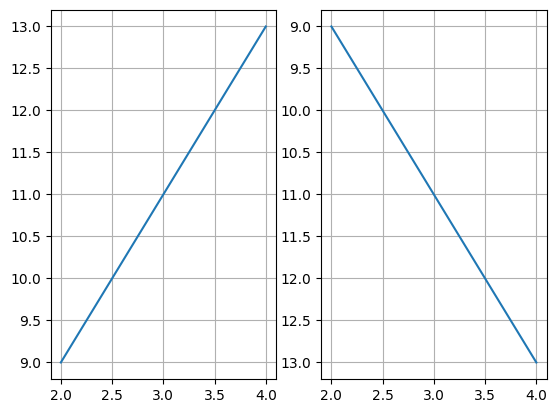

In [ ]:
#testing to make sure plt.gca().invert_yaxis() wont mess up the data:
plt.subplot(1, 2, 1)
x = np.array([2, 3, 4])
y = x * 2 + 5
plt.plot(x, y)
plt.grid(True)

plt.subplot(1, 2, 2)
x = np.array([2, 3, 4])
y = x * 2 + 5
plt.plot(x, y)
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

# ok awesome looks good!

In [ ]:
combined_df = pd.concat([linear_df, circular_df], ignore_index=True)

combined_df


,dEdx_PionPlus_Isolated;1,dEdx_PionMinus_Isolated;1,dEdx_KaonPlus_Isolated;1,dEdx_KaonMinus_Isolated;1,dEdx_ProtonPlus_Isolated;1,dEdx_ProtonMinus_Isolated;1,dEdx_DeuteronPlus_Isolated;1,dEdx_DeuteronMinus_Isolated;1,dEdx_TritonPlus_Isolated;1,dEdx_TritonMinus_Isolated;1,dEdx_HelionPlus_Isolated;1,dEdx_HelionMinus_Isolated;1,dEdx_AlphaPlus_Isolated;1,dEdx_AlphaMinus_Isolated;1,linear,circular
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,1


# Code templete for creating dense matrices

In [36]:
#we might want to store the matrices in a more condensed format that allows us to retain the important data for preprocessing

master = pd.DataFrame()
from scipy.sparse import find
# I'm so happy I found this function because trying to do this on my own was hell! Heres the docs on how it works:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.find.html



def value_getter(df, feature, etype):
    local = pd.DataFrame()
    matrix = df[feature][0]

    # this code below also gives us the same thing, but in a worse format.
    # sparse_m = sparse.csr_matrix(matrix)
    # I'm leaving it in as a comment so that we can check to make sure our rows cols and values are being indexed correctly for all features
    rows, cols, values = find(matrix)
    '''print(sparse_m)
    indptr = sparse_m.indptr
    #this gives you the index where each row starts and ends. For example A= [1,2,3;4,5,6;7,8,9]
    # will look like indptr = [0, 3, 6, 9] because the For row 0, the data starts at index 0 and ends at index 3
    # For row 1, the data starts at index 3 and ends at index 6 and etc
'''
    rows = rows.tolist()
    cols = cols.tolist()
    values = values.tolist()
    print(sparse_m)
    print(rows)
    print(cols)
    print(values)
    '''columns = sparse_m.indices
    rows = rows = sparse_m.indptr[columns]
    values = sparse_m.data
    print(len(values))
    local['position'] = rows
    local['stopping power'] = columns
    local[feature] = values
    etypes_list = []'''

    for i in range(len(columns)):
        etypes_list.append(etype)

        local['type'] = etypes_list
        # to make sure that the alignment stays the same
    return(rows, columns, values)


testing = value_getter(linear_df, tree_names[0], 0)

print(testing)






  (369, 268)	1
  (369, 273)	1
  (370, 233)	1
  (370, 235)	1
  (370, 259)	1
  (370, 265)	1
  (371, 244)	1
  (371, 247)	1
  (371, 266)	1
  (372, 238)	1
  (372, 240)	1
  (372, 241)	2
  (372, 248)	1
  (372, 250)	1
  (372, 251)	1
  (372, 254)	1
  (372, 262)	1
  (372, 285)	1
  (373, 228)	1
  (373, 237)	2
  (373, 239)	1
  (373, 241)	2
  (373, 245)	1
  (373, 246)	1
  (373, 247)	1
  :	:
  (808, 207)	1
  (808, 212)	1
  (808, 238)	1
  (810, 205)	1
  (812, 230)	1
  (813, 221)	1
  (814, 191)	1
  (814, 240)	1
  (816, 247)	1
  (817, 239)	1
  (817, 262)	1
  (818, 263)	1
  (821, 199)	1
  (824, 240)	1
  (824, 241)	1
  (826, 255)	1
  (826, 262)	1
  (827, 208)	1
  (829, 231)	1
  (835, 182)	1
  (836, 238)	1
  (836, 240)	1
  (846, 232)	1
  (862, 178)	1
  (867, 208)	1
[369, 369, 370, 370, 370, 370, 371, 371, 371, 372, 372, 372, 372, 372, 372, 372, 372, 372, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374

NameError: ignored

# one idea is to use CSR matrix which shows the none zero rows and columns. here is an idea of how it works



In [ ]:
# code block for experimenting with different ways of doing this:

for feature in linear_df.columns:
      if feature == 'linear' or feature == 'circular':
        continue
      else:
        matrix = linear_df[feature].values[0][500:1500]
        sparse_m = sparse.csr_matrix(matrix)
        print(sparse_m)
        #print(sparse_m)
        #will print out the indexes of the non zero elements in the format: (row, column), value
        #x / row = position
        #y / column = de/dx change in energy (stopping power)
        #value = count or number of detections at that (x,y) point


  (0, 160)	1
  (0, 162)	2
  (0, 163)	6
  (0, 164)	3
  (0, 165)	7
  (0, 166)	11
  (0, 167)	6
  (0, 168)	14
  (0, 169)	11
  (0, 170)	13
  (0, 171)	15
  (0, 172)	28
  (0, 173)	23
  (0, 174)	29
  (0, 175)	37
  (0, 176)	30
  (0, 177)	58
  (0, 178)	61
  (0, 179)	73
  (0, 180)	74
  (0, 181)	121
  (0, 182)	103
  (0, 183)	138
  (0, 184)	144
  (0, 185)	141
  :	:
  (308, 207)	1
  (308, 212)	1
  (308, 238)	1
  (310, 205)	1
  (312, 230)	1
  (313, 221)	1
  (314, 191)	1
  (314, 240)	1
  (316, 247)	1
  (317, 239)	1
  (317, 262)	1
  (318, 263)	1
  (321, 199)	1
  (324, 240)	1
  (324, 241)	1
  (326, 255)	1
  (326, 262)	1
  (327, 208)	1
  (329, 231)	1
  (335, 182)	1
  (336, 238)	1
  (336, 240)	1
  (346, 232)	1
  (362, 178)	1
  (367, 208)	1
  (0, 159)	3
  (0, 161)	2
  (0, 163)	1
  (0, 164)	4
  (0, 165)	3
  (0, 166)	7
  (0, 167)	6
  (0, 168)	8
  (0, 169)	15
  (0, 170)	22
  (0, 171)	17
  (0, 172)	29
  (0, 173)	30
  (0, 174)	40
  (0, 175)	41
  (0, 176)	46
  (0, 177)	61
  (0, 178)	67
  (0, 179)	74
  (0, 180)	7